> Martin Fridrich, 03/2021

# Evaluating feature importance

This document strives to inspect effect of individual features & feature sets on the clfs performance in user churn prediction problem. For such a task, we utilize original the proposed user model & benchmarked machine learning pipelines. The endevours are structured as follows:

1 [Housekeepin'](#housekeepin)  
2 [Feature importance](#feature-importance)  
3 [Feature set importance](#feature-set-importance)  
4 [Discussion](#discussion)  
5 [Next steps](#next-steps)

# Housekeepin'

In the opening section, we load most of the libs and the pickled data, strats & models.

In [1]:
# set options
import warnings  
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option("notebook_repr_html", False)

# general
import numpy as np
import pickle

# plotting
from cairosvg import svg2png
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns

# others
from sklearn.inspection import permutation_importance
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.neighbors import KernelDensity

# metrics
from sklearn.metrics import make_scorer,accuracy_score, recall_score, precision_score,\
f1_score, roc_auc_score, roc_curve

In [2]:
pf = open("../data/benchmark-cache.pickle","rb")
classification_data, skf, score_dict = pickle.load(pf)
pf.close()
features = classification_data.loc[:,"ses_rec":"int_cat24_n"].columns

# Feature importance

To assess the contribution of individual features to the model's performance, we use a permutation importance procedure. In short, it describes a change in a pipeline's performance when an explanatory variable is randomly shuffled. Thus, it indicates how much the machine learning solution is dependent on that characteristic. We decide to examine changes in both train & test performance in roc auc.

In [3]:
# selected clfs
clf_keys = ["lr", "svm-rbf", "gbm"]

# feature importance on train & test set
split_get = skf.split(classification_data.loc[:,"ses_rec":"int_cat24_n"],
    classification_data.target_class)

importance_df = pd.DataFrame(columns=list(features)+["type", "pipe"])
for i, s in zip(range(skf.get_n_splits()), split_get):
    for k, v in {"train":s[0], "test":s[1]}.items():
        for e in clf_keys:
            temp_imp = permutation_importance(score_dict[e]["estimator"][i],
                X=classification_data[features].iloc[v,:], y=classification_data.target_class[v],
                scoring="roc_auc",n_repeats=10, n_jobs=8).importances
            temp_df = pd.DataFrame(dict(zip(features, temp_imp)))
            temp_df["type"] = k
            temp_df["pipe"] = e
            importance_df = importance_df.append(temp_df)

# diff value
agg_imp_df = importance_df.groupby(["type", "pipe"]).mean().transpose()
# diff/importance rank
importance_rank_df = importance_df.apply(lambda x: x[features].rank(ascending=False, method="max"), axis=1)
importance_rank_df = pd.concat([importance_rank_df, importance_df[["type","pipe"]]], axis=1) 
agg_rank_df = importance_rank_df.groupby(["type","pipe"]).mean().transpose()

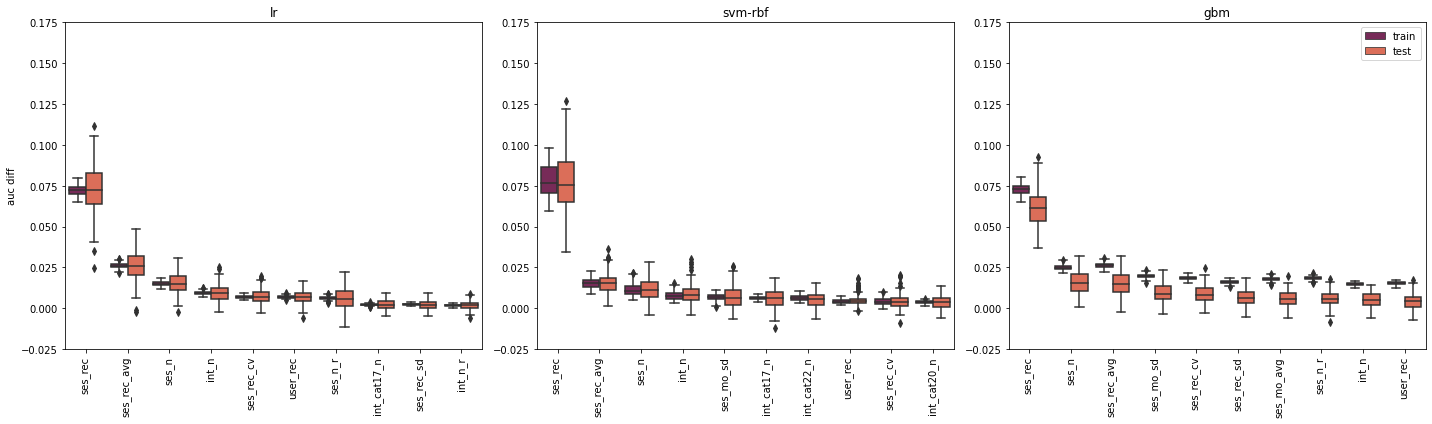

In [4]:
ft_df = pd.melt(importance_df,id_vars=["type","pipe"], var_name="feature", value_name="diff")
fig, axs = plt.subplots(1, 3, figsize=(20,6))
for k, ax in zip(clf_keys, axs.flatten()):  
    tf = agg_imp_df.loc[:,"test"][k].sort_values(ascending=False).index[:10].values
    cf = np.logical_and(ft_df["pipe"]==k, [f in tf for f in ft_df.feature])
    g = sns.boxplot(x="feature", y="diff",
        hue="type", palette="rocket",
        data=ft_df[cf], ax=ax, order=tf)
    g.set_title(k)
    g.set_xlabel("")
    g.set_xticklabels(g.get_xticklabels(), rotation = 90)
    g.set_ylabel("")
    g.set_ylim(-0.025, 0.175)
    g.legend([],[], frameon=False)
axs[0].set_ylabel("auc diff") 
axs[2].legend(loc="upper right");
fig.tight_layout();

The charts above show us how the performance wrt train & test set feature permutations differ. The most prominent features across all clfs are `ses_rec`, `ses_n_r`, and `ses_n`. The median differences range from 0.005-0.105, with a more considerable variance on the test set. Apart from recency + frequency sets, the clfs appear to rely on category items & datetime variables. The disparity of train-test set measures in the gbm plot is caused by moderate overfit of the model.

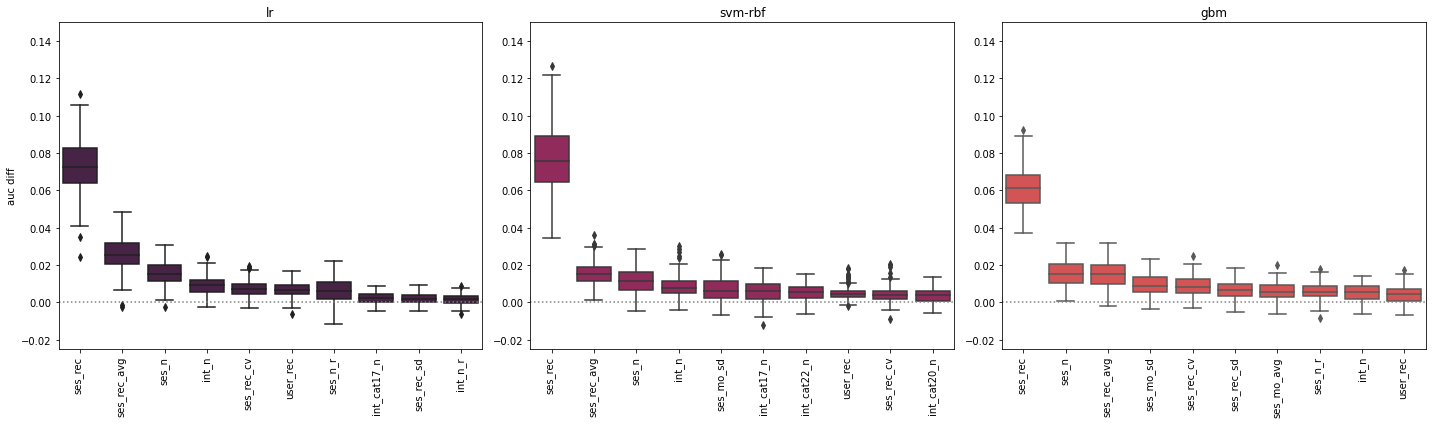

In [5]:
ft_df_ = ft_df[ft_df.type=="test"]
fig, axs = plt.subplots(1, 3, figsize=(20,6))
cp = sns.color_palette("rocket", n_colors=4)
for i, (k, ax) in enumerate(zip(clf_keys, axs.flatten())):  
    tf = agg_imp_df.loc[:,"test"][k].sort_values(ascending=False).index[:10].values
    cf = np.logical_and(ft_df["pipe"]==k, [f in tf for f in ft_df.feature])
    g = sns.boxplot(x="feature", y="diff",
        color=cp[i],
        data=ft_df_[cf], ax=ax, order=tf)
    g.set_title(k)
    g.set_xlabel("")
    g.set_xticklabels(g.get_xticklabels(), rotation = 90)
    g.set_ylabel("")
    g.set_ylim(-0.025, 0.15)
    g.legend([],[], frameon=False)
    g.axhline(0, c="gray", linestyle="dotted")
axs[0].set_ylabel("auc diff") 
#axs[2].legend(loc="upper right");
fig.tight_layout();

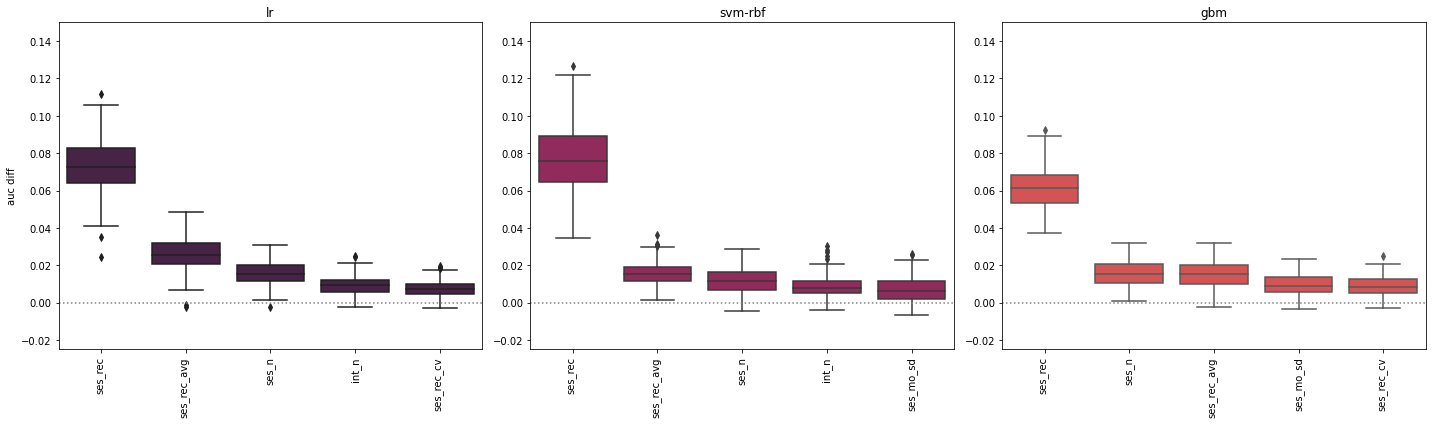

In [6]:
ft_df_ = ft_df[ft_df.type=="test"]
fig, axs = plt.subplots(1, 3, figsize=(20,6))
cp = sns.color_palette("rocket", n_colors=4)
for i, (k, ax) in enumerate(zip(clf_keys, axs.flatten())):  
    tf = agg_imp_df.loc[:,"test"][k].sort_values(ascending=False).index[:5].values
    cf = np.logical_and(ft_df["pipe"]==k, [f in tf for f in ft_df.feature])
    g = sns.boxplot(x="feature", y="diff",
        color=cp[i],
        data=ft_df_[cf], ax=ax, order=tf)
    g.set_title(k)
    g.set_xlabel("")
    g.set_xticklabels(g.get_xticklabels(), rotation = 90)
    g.set_ylabel("")
    g.set_ylim(-0.025, 0.15)
    g.legend([],[], frameon=False)
    g.axhline(0, c="gray", linestyle="dotted")
axs[0].set_ylabel("auc diff") 
#axs[2].legend(loc="upper right");
fig.tight_layout();

In [7]:
# bootastraped means and intervals
prc_ls = [.0005, .005, .025, .05, .95, .975, .995, .9995]
prnt_ls = ["mean","0.5%", "99.5%"]

ind_bootstrap_df = pd.concat([ft_df_.groupby(["pipe","feature"]).\
    sample(frac=1, replace=True, random_state=i).\
    groupby(["pipe","feature"]).mean()for i in range(1000)])

# exp individual importance
ind_bootstrap_df.groupby(["pipe","feature"]).describe(percentiles=prc_ls).\
    to_csv("../data/ecom-user-churn-ind-imp-ci.csv")
# printout
ind_bootstrap_df.groupby(["pipe","feature"]).describe(percentiles=prc_ls).\
    loc[:,pd.IndexSlice[:,["mean","0.5%","99.5%"]]]        

                              diff                            
                              mean          0.5%         99.5%
pipe    feature                                               
gbm     int_cat10_n   6.883163e-05 -3.007600e-05  1.666885e-04
        int_cat11_n  -4.845406e-06 -2.187588e-05  6.118430e-06
        int_cat12_n  -1.605435e-04 -3.425509e-04  1.180695e-05
        int_cat13_n   6.685040e-06 -8.347771e-06  2.503723e-05
        int_cat15_n   8.265039e-08  3.244373e-08  1.541483e-07
...                            ...           ...           ...
svm-rbf time_to_int   9.511244e-05 -3.278028e-04  4.755261e-04
        time_to_tran -1.681344e-04 -4.612725e-04  1.164541e-04
        tran_n       -1.849520e-04 -4.416403e-04  7.035484e-05
        tran_n_r     -1.810385e-04 -4.312587e-04  3.498347e-05
        user_rec      4.580990e-03  4.052562e-03  5.202870e-03

[141 rows x 3 columns]

In [8]:
# p-vals on means, null hypothesis mean characteristic higher than zero
pind_bootstrap_df = ind_bootstrap_df.groupby(["pipe","feature"]).apply(lambda x: x>0).\
    astype("float").groupby(["pipe","feature"]).mean()
# export
pind_bootstrap_df.to_csv("../data/ecom-user-churn-ind-imp-pval.csv")
# printout
pind_bootstrap_df

                       diff
pipe    feature            
gbm     int_cat10_n   0.938
        int_cat11_n   0.186
        int_cat12_n   0.008
        int_cat13_n   0.831
        int_cat15_n   1.000
...                     ...
svm-rbf time_to_int   0.742
        time_to_tran  0.054
        tran_n        0.037
        tran_n_r      0.029
        user_rec      1.000

[141 rows x 1 columns]

# Feature set importance

To evaluate the set importance, we treat a set as predictions of the most influential features. Thus, we are able measure precision & recall for each feature group. Let us have a set of features $G$, set of n most influential features $F_n$, then:

$pre_G = \frac{|\{g|g \in F_n\}|}{|G|}$,  
$rec_G = \frac{|\{g|g \in F_n\}|}{n}$,  
$f1_G = \frac{2 \cdot pre_G \cdot rec_G}{pre_G+rec_G}$.  

We combine the outlined idea with monte-carlo to construct distribution for the metrics at hand. The proposed procedure is as follows: (1) draw random 10^5 permutations of the rank vector, (2) compute pre-rec point estimate for each vector, (3) form the pre-rec distributions from the point estimates. Consequently, we are able to place observed classifier feature preference to the random feature preference.

In [9]:
# feature set map
fg_map = [("recency","ses_rec"), ("recency","ses_rec_avg"), ("recency","ses_rec_sd"),
("recency","ses_rec_cv"), ("recency","user_rec"),
("frequency","ses_n"), ("frequency","ses_n_r"), ("frequency","int_n"),
("frequency","int_n_r"), ("frequency","tran_n"), ("frequency","tran_n_r"),
("monetary","rev_sum"), ("monetary","rev_sum_r"), ("monetary","major_spend_r"),
("category_items","int_cat_n_avg"), ("category_items","int_itm_n_avg"),
("category_items","int_cat1_n"),("category_items","int_cat2_n"),("category_items","int_cat3_n"),
("category_items","int_cat4_n"), ("category_items","int_cat5_n"),("category_items","int_cat6_n"),
("category_items","int_cat7_n"), ("category_items","int_cat8_n"),("category_items","int_cat9_n"),
("category_items","int_cat10_n"),("category_items","int_cat11_n"), ("category_items","int_cat12_n"),
("category_items","int_cat13_n"), ("category_items","int_cat14_n"), ("category_items","int_cat15_n"),
("category_items","int_cat16_n"), ("category_items","int_cat17_n"), ("category_items","int_cat18_n"),
("category_items","int_cat19_n"), ("category_items","int_cat20_n"), ("category_items","int_cat21_n"),
("category_items","int_cat22_n"), ("category_items","int_cat23_n"), ("category_items","int_cat24_n"),
("datetime","ses_mo_avg"), ("datetime","ses_mo_sd"), ("datetime","ses_ho_avg"),
("datetime","ses_ho_sd"), ("datetime","ses_wknd_r"),
("others","ses_len_avg"), ("others","time_to_int"), ("others","time_to_tran")]
fg_dict = dict((e[1],e[0]) for e in fg_map if e[1] in ft_df.feature.unique())

In [10]:
# monte-carlo & reshapes
def shape_rank(df, fg=fg_dict, recolumn=False):
    df.reset_index(drop=True, inplace=True)
    df.index = ["iter_"+str(c) for c in df.index]
    if recolumn:
        df.columns = fg.keys()
    df = df[fg.keys()]
    df = df.T
    df["group"] = df.index.map(fg)
    return df

def pre_rec(df, k=10):
    ic = [c for c in df.columns if "iter" in c]
    hits_df = (df.loc[:,ic]<=k).sum()
    pre = hits_df/df.shape[0]
    rec = hits_df/k
    res_df = pd.DataFrame({"precision":pre, "recall":rec,
        "f1":(2*pre*rec/(pre+rec+0.0001))})
    res_df = res_df.apply(pd.to_numeric)
    return res_df    

mc_ls = []
for i in range(10**4):
    arr = np.arange(len(fg_dict))+1
    np.random.seed(i)
    np.random.shuffle(arr)
    mc_ls.append(arr)
mc_df = pd.DataFrame(mc_ls)
mc_df = shape_rank(mc_df, fg_dict, True)

mcm_df = mc_df.groupby(mc_df.group).apply(pre_rec, 10)
mcm_df.index.set_names(["feature_set","iter"], inplace=True)
mcm_df.reset_index(inplace=True)

# check the results
feature_sets = ["recency", "frequency", "monetary", "category_items", "datetime", "others"]
#display(mcm_df.groupby("feature_set").precision.describe(percentiles=prc_ls)[prnt_ls])
#display(mcm_df.groupby("feature_set").recall.describe(percentiles=prc_ls)[prnt_ls])
mcm_df.groupby("feature_set").describe(percentiles=prc_ls).loc[:,pd.IndexSlice[:,prnt_ls]]

               precision                   recall                   f1  \
                    mean  0.5%     99.5%     mean 0.5% 99.5%      mean   
feature_set                                                              
category_items  0.212996  0.08  0.360000  0.53249  0.2   0.9  0.304239   
datetime        0.212160  0.00  0.800000  0.10608  0.0   0.4  0.141408   
frequency       0.212517  0.00  0.666667  0.12751  0.0   0.4  0.159351   
monetary        0.212200  0.00  1.000000  0.06366  0.0   0.3  0.097920   
others          0.212733  0.00  1.000000  0.06382  0.0   0.3  0.098166   
recency         0.212880  0.00  0.600000  0.10644  0.0   0.3  0.141888   

                                    
                    0.5%     99.5%  
feature_set                         
category_items  0.114245  0.514245  
datetime        0.000000  0.533289  
frequency       0.000000  0.499953  
monetary        0.000000  0.461503  
others          0.000000  0.461503  
recency         0.000000  0.399956  

We can see that sets with the high potential importance are the largest, with the most notable contributors in `category_items`, `frequency`, `recency` or `datetime`.

In [11]:
o_ls = []
for c in clf_keys:
    cf = (importance_rank_df["type"]=="test") & (importance_rank_df["pipe"]==c)
    df = shape_rank(importance_rank_df.loc[cf, list(fg_dict.keys())])
    df = df.groupby("group").apply(pre_rec)
    df.index = pd.MultiIndex.from_tuples([(c, cat, it) for cat, it in df.index.values],
        names=["clf","feature_set","iter"])
    o_ls.append(df)
om_df = pd.concat(o_ls).reset_index()
om_df.groupby(["clf","feature_set"]).mean().loc[pd.IndexSlice[:, feature_sets],:] # observed means

                        precision  recall        f1
clf     feature_set                                
gbm     recency          0.828000  0.4140  0.551956
lr      recency          0.854000  0.4270  0.569289
svm-rbf recency          0.667000  0.3335  0.444622
gbm     frequency        0.411667  0.2470  0.308703
lr      frequency        0.516667  0.3100  0.387453
svm-rbf frequency        0.375000  0.2250  0.281205
gbm     monetary         0.000000  0.0000  0.000000
lr      monetary         0.000000  0.0000  0.000000
svm-rbf monetary         0.000000  0.0000  0.000000
gbm     category_items   0.047800  0.1195  0.068254
lr      category_items   0.078600  0.1965  0.112247
svm-rbf category_items   0.130200  0.3255  0.185959
gbm     datetime         0.408000  0.2040  0.271956
lr      datetime         0.133000  0.0665  0.088642
svm-rbf datetime         0.228000  0.1140  0.151964
gbm     others           0.051667  0.0155  0.023841
lr      others           0.000000  0.0000  0.000000
svm-rbf othe

In [12]:
# bootastraped means and intervals
set_bootstrap_df = pd.concat([om_df.groupby(["clf","feature_set"]).\
    sample(frac=1, replace=True, random_state=i).\
    groupby(["clf","feature_set"]).mean()for i in range(1000)])

# exp set importance
set_bootstrap_df.groupby(["clf","feature_set"]).describe(percentiles=prc_ls).\
    to_csv("../data/ecom-user-churn-set-imp-ci.csv")    

# printout
set_bootstrap_df.groupby(["clf","feature_set"]).describe(percentiles=prc_ls).\
    loc[pd.IndexSlice[:,feature_sets],pd.IndexSlice[:,["mean","0.5%","99.5%"]]]    

                       precision                        recall            \
                            mean      0.5%     99.5%      mean      0.5%   
clf     feature_set                                                        
gbm     recency         0.827876  0.800000  0.859005  0.413938  0.400000   
lr      recency         0.853988  0.832000  0.876000  0.426994  0.416000   
svm-rbf recency         0.667751  0.636000  0.698005  0.333875  0.318000   
gbm     frequency       0.411783  0.390833  0.434175  0.247070  0.234500   
lr      frequency       0.516393  0.495000  0.538338  0.309836  0.297000   
svm-rbf frequency       0.374757  0.345821  0.399171  0.224854  0.207493   
gbm     monetary        0.000000  0.000000  0.000000  0.000000  0.000000   
lr      monetary        0.000000  0.000000  0.000000  0.000000  0.000000   
svm-rbf monetary        0.000000  0.000000  0.000000  0.000000  0.000000   
gbm     category_items  0.047610  0.041199  0.054000  0.119024  0.102997   
lr      cate

In [13]:
# p-vals on means, null hypothesis mean characteristic higher than zero
pset_bootstrap_df = set_bootstrap_df.groupby(["clf","feature_set"]).apply(lambda x: x>0).\
    astype("float").groupby(["clf","feature_set"]).mean().loc[pd.IndexSlice[:,feature_sets],:]
# export
pset_bootstrap_df.to_csv("../data/ecom-user-churn-set-imp-pval.csv")
# printout
pset_bootstrap_df

                        precision  recall     f1
clf     feature_set                             
gbm     recency             1.000   1.000  1.000
lr      recency             1.000   1.000  1.000
svm-rbf recency             1.000   1.000  1.000
gbm     frequency           1.000   1.000  1.000
lr      frequency           1.000   1.000  1.000
svm-rbf frequency           1.000   1.000  1.000
gbm     monetary            0.000   0.000  0.000
lr      monetary            0.000   0.000  0.000
svm-rbf monetary            0.000   0.000  0.000
gbm     category_items      1.000   1.000  1.000
lr      category_items      1.000   1.000  1.000
svm-rbf category_items      1.000   1.000  1.000
gbm     datetime            1.000   1.000  1.000
lr      datetime            1.000   1.000  1.000
svm-rbf datetime            1.000   1.000  1.000
gbm     others              1.000   1.000  1.000
lr      others              0.000   0.000  0.000
svm-rbf others              0.946   0.946  0.946

We reject the null hypothesis only for the monetary feature set with importance described by `lr` and `gbm`. Mean point estimates for other sets & metrics appear to be higher than zero. Now, we take a look on difference in means between the observed and reference importance set measures.

In [14]:
# bootstrapped observed - reference
set_diff_bootstrap_df = pd.concat([om_df.groupby(["clf","feature_set"]).\
    sample(frac=1, replace=True, random_state=i).groupby(["clf","feature_set"]).mean()-\
    mcm_df.groupby("feature_set").sample(frac=1, replace=True, random_state=i).\
        groupby("feature_set").mean() for i in range(1000)])
# exp
set_diff_bootstrap_df.groupby(["clf","feature_set"]).describe(percentiles=prc_ls).\
    to_csv("../data/ecom-user-churn-set-diff.csv")
# printout        
set_diff_bootstrap_df.groupby(["clf","feature_set"]).describe(percentiles=prc_ls).\
    loc[pd.IndexSlice[:,feature_sets],pd.IndexSlice[:,["mean","0.5%","99.5%"]]] 

                       precision                        recall            \
                            mean      0.5%     99.5%      mean      0.5%   
clf     feature_set                                                        
gbm     recency         0.615033  0.586438  0.646508  0.307516  0.293219   
lr      recency         0.641145  0.618439  0.664028  0.320572  0.309220   
svm-rbf recency         0.454908  0.425643  0.486064  0.227454  0.212822   
gbm     frequency       0.199198  0.178083  0.221467  0.119519  0.106850   
lr      frequency       0.303808  0.280547  0.327317  0.182285  0.168328   
svm-rbf frequency       0.162171  0.134230  0.188418  0.097303  0.080538   
gbm     monetary       -0.212206 -0.218433 -0.205733 -0.063662 -0.065530   
lr      monetary       -0.212206 -0.218433 -0.205733 -0.063662 -0.065530   
svm-rbf monetary       -0.212206 -0.218433 -0.205733 -0.063662 -0.065530   
gbm     category_items -0.165379 -0.172148 -0.159058 -0.413449 -0.430370   
lr      cate

In addition, we examine the p-values for the mean differences, where null hypothesis stands that the difference in means is not positive, i.e., the observed importance metric shows same or lower value than randomly observed importance of a set of the same size. 

In [15]:
# p-vals to the boostraped diff
pset_diff_bootstrap_df = set_diff_bootstrap_df.groupby(["clf","feature_set"]).apply(lambda x: x<=0).\
    astype("float").groupby(["clf","feature_set"]).mean().loc[pd.IndexSlice[:,feature_sets],:]
# export
pset_diff_bootstrap_df.to_csv("../data/ecom-user-churn-set-diff-pval.csv")
# printout
pset_diff_bootstrap_df    

                        precision  recall     f1
clf     feature_set                             
gbm     recency             0.000   0.000  0.000
lr      recency             0.000   0.000  0.000
svm-rbf recency             0.000   0.000  0.000
gbm     frequency           0.000   0.000  0.000
lr      frequency           0.000   0.000  0.000
svm-rbf frequency           0.000   0.000  0.000
gbm     monetary            1.000   1.000  1.000
lr      monetary            1.000   1.000  1.000
svm-rbf monetary            1.000   1.000  1.000
gbm     category_items      1.000   1.000  1.000
lr      category_items      1.000   1.000  1.000
svm-rbf category_items      1.000   1.000  1.000
gbm     datetime            0.000   0.000  0.000
lr      datetime            1.000   1.000  1.000
svm-rbf datetime            0.064   0.064  0.064
gbm     others              1.000   1.000  1.000
lr      others              1.000   1.000  1.000
svm-rbf others              1.000   1.000  1.000

From the print-out above, we see that only `recency` and `frequency` outperform the referential distributions in all metrics & classifiers on p<0.001. Datetime group appears to be also significant for more complex `svm-rbf` and `gbm`.

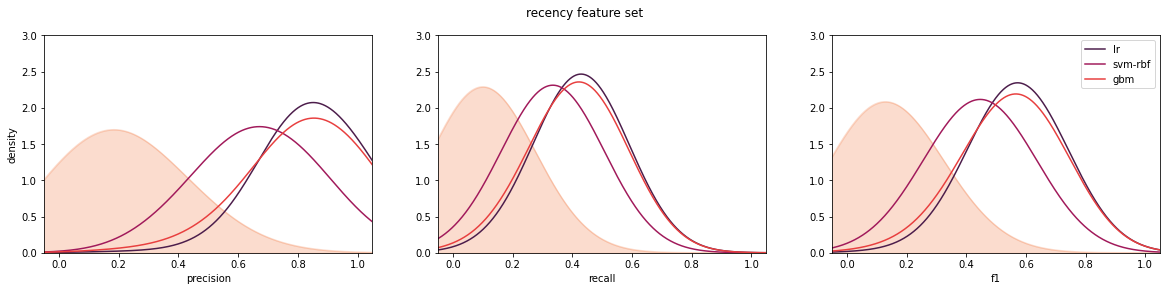

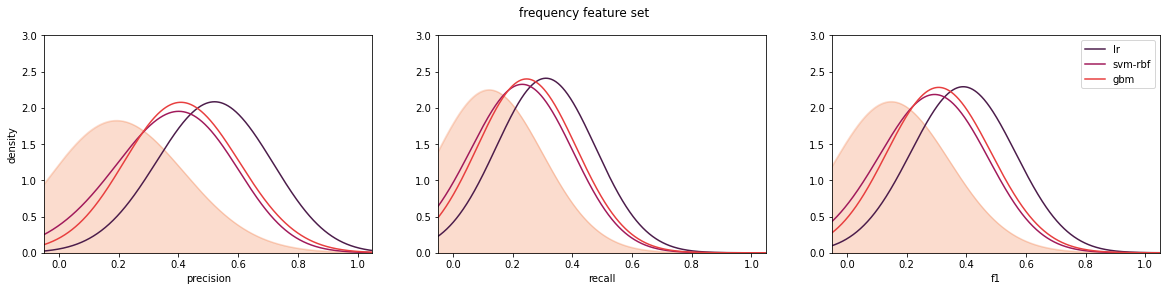

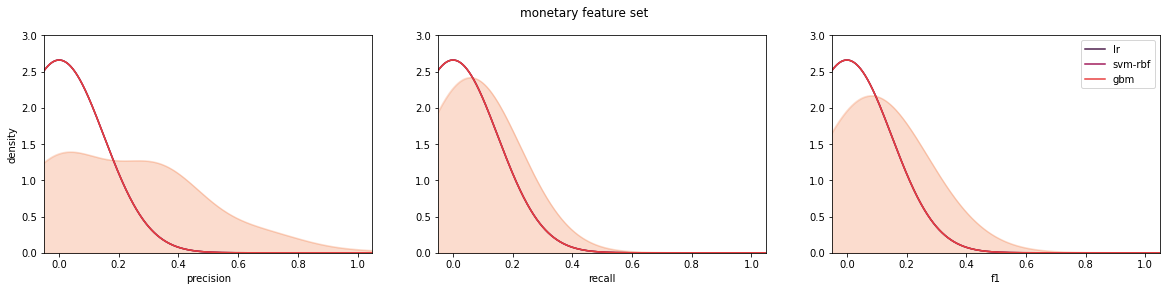

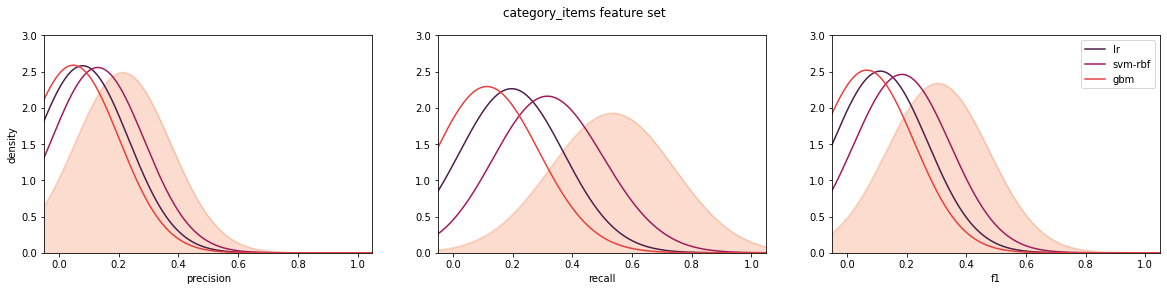

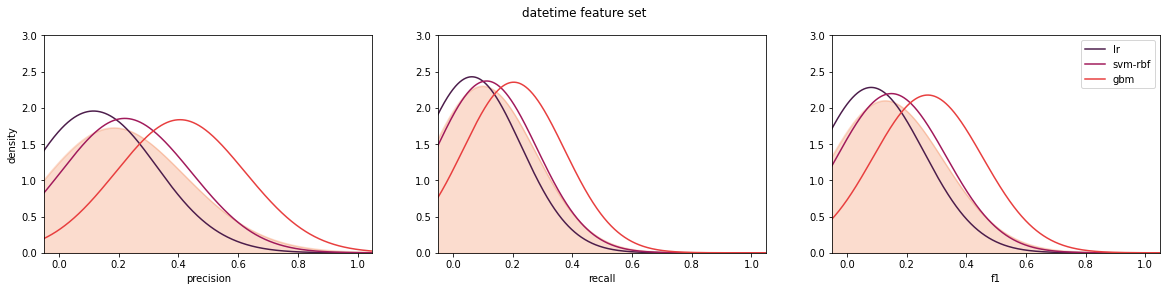

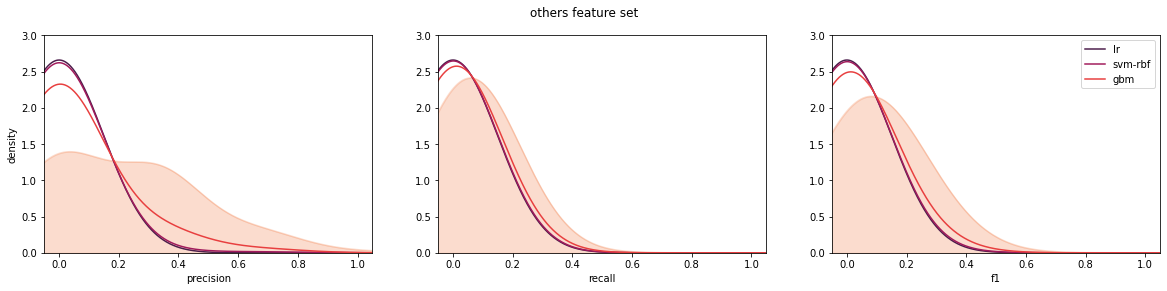

In [16]:
# predef
X_plot = np.linspace(-0.1,1.1,1000)
cv_params = {"bandwidth":np.linspace(0.15,1.5,100), "kernel":["gaussian"]}
cp = sns.color_palette("rocket", n_colors=4)
metric_keys = ["precision", "recall", "f1"]

def get_kde(X_train, X_predict, cv_grid=None, **cv_kwargs):
    X_train = X_train.values.reshape(-1,1)
    cv = HalvingGridSearchCV(KernelDensity(),
        param_grid=cv_grid, **cv_kwargs).fit(X_train)
    y_predict = cv.score_samples(X_predict.reshape(-1,1))
    return np.exp(y_predict)

# plot reference distribution
for s in feature_sets:
    mcf = mcm_df.feature_set==s
    ocf = om_df.feature_set==s
    fig, axs = plt.subplots(1,3, figsize=(20,4))
    for m, ax in zip(metric_keys, axs):
        mcm_kde = get_kde(mcm_df[mcf][m], X_plot,
            cv_grid=cv_params, n_jobs=8, max_resources=1000)
        sns.lineplot(x=X_plot,y=mcm_kde, alpha=0.35, ax=ax, color=cp[3])
        ax.fill_between(X_plot,mcm_kde, color=cp[3], alpha=0.35)
        for i, c in enumerate(clf_keys):
            om_kde = get_kde(om_df[(ocf) & (om_df.clf==c)][m], X_plot,
                cv_grid=cv_params, n_jobs=8)
            sns.lineplot(x=X_plot,y=om_kde, ax=ax, color=cp[i], label=c,
                legend=False)
        ax.set_xlim(-0.05,1.05)
        ax.set_xlabel(m)
        ax.set_ylim(0,3)
        ax.set_ylabel("")
    fig.suptitle(s + " feature set")
    axs[0].set_ylabel("density")
    axs[2].legend(loc="upper right")
    plt.show()

In the plots above, we identify four types of the set importance behavior: (1) group over-performs monte-carlo ranks, examples - recency, frequency, suggestion - stabilize the precision (feature preselection) (2) under-performing the simulation; however, still somewhat functional, examples - category_items, suggestion - improve the precision (preselection, dense representation), (3) datetime set performs on par with random ranks, suggestion - NA (4) others & monetary groups are vastly under-performing, suggestion - omit.

# Discussion

TBD - broadly discuss the benchmark, feature & feature set importance in the business context.

# Next steps

**Modeling/Feature importance**  
 * review feature set procedure,
 * review discussion/bechmark results,
 * ...

**Project**  
 * discuss goal, consider breaking the work down to more pieces,
 * discuss on suitable journal,
 * ...